Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [69]:
import pandas as pd
adoption_url = 'https://data.austintexas.gov/resource/9t4d-g238.csv?$limit=100000'
adoption = pd.read_csv(adoption_url)
# in order to see all of the columns:
pd.options.display.max_columns = 100

# Target

In [70]:
adoption.head()

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A644452,Acho,2019-11-21T19:27:00.000,2019-11-21T19:27:00.000,2010-12-27T00:00:00.000,Adoption,NaN,Dog,Neutered Male,8 years,Pit Bull Mix,Brown Brindle/White
1,A808270,NaN,2019-11-21T18:54:00.000,2019-11-21T18:54:00.000,2017-11-06T00:00:00.000,Transfer,Snr,Cat,Neutered Male,2 years,Domestic Shorthair,Cream Tabby/White
2,A808779,NaN,2019-11-21T18:54:00.000,2019-11-21T18:54:00.000,2019-08-26T00:00:00.000,Transfer,Snr,Cat,Unknown,2 months,Domestic Shorthair,Blue Tabby/White
3,A808989,NaN,2019-11-21T18:51:00.000,2019-11-21T18:51:00.000,2018-11-17T00:00:00.000,Transfer,Partner,Dog,Intact Male,1 year,Pug,Fawn
4,A809023,NaN,2019-11-21T18:37:00.000,2019-11-21T18:37:00.000,2017-11-17T00:00:00.000,Adoption,NaN,Dog,Spayed Female,2 years,Boykin Span Mix,Red


In [71]:
adoption.shape

(100000, 12)

The target in this project will be to predict whether or not an animal will be adopted or not (transferred to another shelter or, sadly, euthanized) so that perhaps animal shelters, though overwhelmed, can give some extra love or use unique methods to get those animals that may not have the best odds forever homes.

In [72]:
adoption['outcome_type'].value_counts(dropna=False)

Adoption           44422
Transfer           29846
Return to Owner    17523
Euthanasia          6258
Died                 963
Rto-Adopt            516
Disposal             391
Missing               61
Relocate              17
NaN                    3
Name: outcome_type, dtype: int64

In [73]:
# this might be a feature that can create leakage, will come back to it.
adoption['outcome_subtype'].value_counts(dropna=False)

NaN                    54877
Partner                24927
Foster                  7967
Rabies Risk             2774
SCRP                    2617
Suffering               2488
Snr                     2299
In Kennel                507
Aggressive               355
Offsite                  279
Medical                  252
In Foster                243
At Vet                   171
Behavior                  82
Enroute                   64
Underage                  29
Court/Investigation       21
In Surgery                19
Possible Theft            15
Field                      8
Barn                       4
Prc                        1
Customer S                 1
Name: outcome_subtype, dtype: int64

# Classification or Regression?

There are 9 classes of outcomes but for this project I'd like to focus on the animals that were adopted or not. There are a large number of animals that were returned to owners but that would just be due to them getting out etc but they do have a home so I will not include those in my project. "Rto-adopt" or return to owner adoption will also be included with "return to owner."

For animals that were adopted I will consider that to be:  
-adoption  
-rto-adopt (return to owner through adoption)  


I will combine the following for not adopted:  
-transfer  
-euthanasia  
-relocate  
-missing (animals that went missing from the shelter--still unsuccessful in getting them homes)  
"Died" and "disposal" are animals that may have died while at the shelter or were brought in that needed to be properly disposed of so I will not include these either as they may have been very ill when brought in.

# How is the target distributed?
## Are the classes imbalanced?

In [74]:
adoption['outcome_type'].value_counts(normalize=True)

Adoption           0.444233
Transfer           0.298469
Return to Owner    0.175235
Euthanasia         0.062582
Died               0.009630
Rto-Adopt          0.005160
Disposal           0.003910
Missing            0.000610
Relocate           0.000170
Name: outcome_type, dtype: float64

will need to drop the rows where the outcome type are the ones listed above to be excluded:  
-Return to owner  
-Rto-adopt  
-Died  
-Disposal


In [75]:
# adoption updated to drop the outcomes we are excluding:
adoption_upd = adoption[~adoption['outcome_type'].isin(['Return to Owner', 
                                                        'Rto-Adopt', 
                                                        'Died', 
                                                        'Disposal'])]

In [76]:
adoption_upd['outcome_type'].value_counts(dropna=False)

Adoption      44422
Transfer      29846
Euthanasia     6258
Missing          61
Relocate         17
NaN               3
Name: outcome_type, dtype: int64

In [77]:
# am going to drop all animals except cats and dogs, 2 of the unknown
# outcome types are dogs and 1 also has a lot of other missing info so
# will drop these rows.
adoption_upd = adoption_upd.dropna(subset = ['outcome_type'])


In [78]:
# need to redefine classes as binary. Adoption as 'adopted' and 
# the rest as 'not adopted'.
def new_status(outcome):
    if outcome == 'Transfer' or outcome == 'Euthanasia' or outcome == 'Missing' or outcome == 'Relocate':
      return 'Not adopted'
    else:
      return 'Adopted'


In [79]:
adoption_upd = adoption_upd.copy()
adoption_upd['outcome'] = adoption_upd['outcome_type'].apply(new_status)

In [80]:
adoption_upd['outcome'].value_counts(normalize=True)

Adopted        0.551114
Not adopted    0.448886
Name: outcome, dtype: float64

The classes now are combined into a binary classification and the classes are not imbalanced.

In [81]:
# drop the original 'Outcome_Type' column:
adoption_upd = adoption_upd.drop(columns='outcome_type')

# Choose Observations

As mentioned above, since the focus of my project is predicting if animals that are in need of forever homes will be adopted or not, I have already excluded the following observations from my model:  
-Return to Owner  
-Rto-Adopt  
-Died  
-Disposal  

There are 3 missing values for the outcome ,so we can try to look at the outcome subtype to see if we can determine what happened to them but the remaining animals have been categorized into 'adopted' or 'not adopted.'

# How to Split Data:

In [82]:
adoption_upd.dtypes

animal_id           object
name                object
datetime            object
monthyear           object
date_of_birth       object
outcome_subtype     object
animal_type         object
sex_upon_outcome    object
age_upon_outcome    object
breed               object
color               object
outcome             object
dtype: object

In [83]:
adoption_upd['datetime'] = pd.to_datetime(adoption_upd['datetime'], infer_datetime_format=True)

In [84]:
adoption_upd['datetime'].dt.year.value_counts()

2015    14792
2019    14648
2016    14119
2017    14058
2018    13361
2014     9626
Name: datetime, dtype: int64

The description of the data set said that Austin is becoming a more pet-friendly city so there may be more animals going in and out of shelters in the more recent data vs the earlier data. I will therefore split the data based on time with the most recent data being the test set and then create a test and validation set with the remaining data.  

test = adoption_upd[(adoption_upd['datetime'].dt.year == 2019)]  
val =  adoption_upd[(adoption_upd['datetime'].dt.year == 2018)]  
train = adoption_upd[(adoption_upd['datetime'].dt.year < 2018)]

In [85]:
# how big to make test set? 2019:
# 14292 observations

# Evaluation Metrics

since the classes aren't imbalanced I can use accuracy but will also explore the precision and recall for this problem.

precision positive: correctly predict all the animals that were adopted.  

\begin{align}
precision = \frac{accurately \ predicted \ adopted}{total\ predicted \ adopted}
\end{align}


recall positive: of all the animals that were adopted, how many were we able to identify?
\begin{align}
recall = \frac{accurately \ predicted \ adopted}{actually \ adopted}
\end{align}


# Begin to clean data and feature selection

In [86]:
adoption_upd.isnull().sum()

animal_id               0
name                30005
datetime                0
monthyear               0
date_of_birth           0
outcome_subtype     36370
animal_type             0
sex_upon_outcome        1
age_upon_outcome       23
breed                   0
color                   0
outcome                 0
dtype: int64

In [87]:
# the outcome subtype is missing 36353 values, almost half of all of our 
# data, since we will know all of the outcome types and this may cause 
# leakage into the test set because certain outcomes can be deduced from 
# the outcome subtype, I will drop that entire column.

adoption_upd = adoption_upd.drop(columns='outcome_subtype')
adoption_upd.shape


(80604, 11)

In [88]:
# the sex_upon_outcome column has 2 missing values but noticed an 'unknown'
# value so check to see if that's common:
adoption_upd['sex_upon_outcome'].value_counts()

Neutered Male    27589
Spayed Female    26041
Intact Female    10077
Intact Male       9345
Unknown           7551
Name: sex_upon_outcome, dtype: int64

In [89]:
# age_upon_outcome has 25 missing values but date_of_birth has none, lets
# look at how many times 'unknown' shows up in the data:
adoption_upd.isin(['Unknown']).sum()
# the name already has 18 unknowns, so will stick to changing NaN's to unknown.

animal_id              0
name                  18
datetime               0
monthyear              0
date_of_birth          0
animal_type            0
sex_upon_outcome    7551
age_upon_outcome       0
breed                  0
color                  0
outcome                0
dtype: int64

In [90]:
# to see if 'Other is a common entry as well'
adoption_upd.isin(['Other']).sum()

animal_id              0
name                   0
datetime               0
monthyear              0
date_of_birth          0
animal_type         4430
sex_upon_outcome       0
age_upon_outcome       0
breed                  0
color                  0
outcome                0
dtype: int64

In [91]:
# to see what kind of animals come in to the shelter
adoption_upd['animal_type'].value_counts()

Dog          39770
Cat          35965
Other         4430
Bird           430
Livestock        9
Name: animal_type, dtype: int64

In [92]:
#thinking of only using cats and dogs.
adoption_upd = adoption_upd[~adoption_upd['animal_type'].isin(['Bird', 
                                                        'Other', 
                                                        'Livestock'])]

In [93]:
# check for missing values now:
adoption_upd.isnull().sum()

animal_id               0
name                25813
datetime                0
monthyear               0
date_of_birth           0
animal_type             0
sex_upon_outcome        1
age_upon_outcome        7
breed                   0
color                   0
outcome                 0
dtype: int64

In [94]:
adoption_upd['date_of_birth'] = pd.to_datetime(adoption_upd['date_of_birth'], infer_datetime_format=True)

In [95]:
adoption_upd.loc[adoption_upd['age_upon_outcome'].isnull()]

,animal_id,name,datetime,monthyear,date_of_birth,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome
80,A809158,NaN,2019-11-20 12:17:00,2019-11-20T12:17:00.000,2017-11-20,Cat,Unknown,NaN,Domestic Medium Hair,White/Black,Not adopted
129,A809016,NaN,2019-11-19 12:36:00,2019-11-19T12:36:00.000,2012-11-17,Cat,Intact Male,NaN,Domestic Shorthair,Black/White,Not adopted
416,A808636,NaN,2019-11-13 13:46:00,2019-11-13T13:46:00.000,2004-11-11,Cat,Intact Female,NaN,Siamese,Seal Point,Not adopted
488,A808649,NaN,2019-11-11 17:49:00,2019-11-11T17:49:00.000,2019-10-11,Cat,Intact Male,NaN,Domestic Shorthair,Brown Tabby,Not adopted
520,A808626,NaN,2019-11-11 13:57:00,2019-11-11T13:57:00.000,2019-09-11,Cat,Intact Female,NaN,Domestic Shorthair,Brown Tabby,Not adopted
573,A808466,NaN,2019-11-10 09:35:00,2019-11-10T09:35:00.000,2019-09-09,Cat,Intact Male,NaN,Domestic Shorthair,Brown/Black,Not adopted
7006,A752967,Gray,2019-07-24 11:42:00,2019-07-24T11:42:00.000,2015-06-29,Dog,NaN,NaN,Pit Bull Mix,Blue/White,Not adopted


In [96]:
# 2 of the rows that are missing the age are also missing the sex so I will
# drop those:
adoption_upd = adoption_upd.dropna(subset = ['sex_upon_outcome'])

In [97]:
# since there are no missing or unknown values for DOB which still seems strange 
# especially for stray animals that were found but maybe they approximated. We can 
# create a column where we subtract 2019 from the born on year to get the age and see 
# if there are a lot of differences.

now = pd.Timestamp('now')
# first, get DOB year column and DOB month columns:
adoption_upd['DOB_month'] = adoption_upd['date_of_birth'].dt.month
# now, subtract current year from DOB year:
adoption_upd['DOB_year'] = now.year - adoption_upd['date_of_birth'].dt.year
# now turn DOB_year into months by multiplying by 12
adoption_upd['DOB_year'] = adoption_upd['DOB_year'] * 12
# add DOB_year which is now in months to DOB month and divide by 12 to get years
adoption_upd['calculated_age'] = adoption_upd['DOB_year'] + adoption_upd['DOB_month']
def calculate_age(age):
        if age >= 12:
            return(f'{age // 12} years')
        else:
            return(f'{age} months') 
adoption_upd['calculated_age'] = adoption_upd['calculated_age'].apply(calculate_age)
# fill NaN's in age upon outcome column with calculated age
adoption_upd['age_upon_outcome'].fillna(adoption_upd['calculated_age'], inplace=True)
# drop DOB month, DOB year, calculated age:
adoption_upd.drop(columns =['DOB_month', 'DOB_year', 'calculated_age'], inplace=True)

In [98]:
adoption_upd.isnull().sum()
# will drop the name column, no more missing values!

animal_id               0
name                25813
datetime                0
monthyear               0
date_of_birth           0
animal_type             0
sex_upon_outcome        0
age_upon_outcome        0
breed                   0
color                   0
outcome                 0
dtype: int64

In [99]:
# drop name:
adoption_upd=adoption_upd.drop(columns=['name'])

In [100]:
adoption_upd.head()

,animal_id,datetime,monthyear,date_of_birth,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome
0,A644452,2019-11-21 19:27:00,2019-11-21T19:27:00.000,2010-12-27,Dog,Neutered Male,8 years,Pit Bull Mix,Brown Brindle/White,Adopted
1,A808270,2019-11-21 18:54:00,2019-11-21T18:54:00.000,2017-11-06,Cat,Neutered Male,2 years,Domestic Shorthair,Cream Tabby/White,Not adopted
2,A808779,2019-11-21 18:54:00,2019-11-21T18:54:00.000,2019-08-26,Cat,Unknown,2 months,Domestic Shorthair,Blue Tabby/White,Not adopted
3,A808989,2019-11-21 18:51:00,2019-11-21T18:51:00.000,2018-11-17,Dog,Intact Male,1 year,Pug,Fawn,Not adopted
4,A809023,2019-11-21 18:37:00,2019-11-21T18:37:00.000,2017-11-17,Dog,Spayed Female,2 years,Boykin Span Mix,Red,Adopted


In [101]:
# looking at redundant columns, date of birth can be dropped since the ages are all accounted for.
# also datetime and monthyear are the same, I will get rid of datetime for now.
adoption_upd.drop(columns=['date_of_birth'], inplace=True)

In [102]:
# going to create a new column for the season the animal came into the shelter to see if certain
# seasons have higher adoption rates:
adoption_upd['monthyear'] = pd.to_datetime(adoption_upd['monthyear'], infer_datetime_format=True)
adoption_upd['month_arrived'] = adoption_upd['monthyear'].dt.month
adoption_upd.head()


,animal_id,datetime,monthyear,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome,month_arrived
0,A644452,2019-11-21 19:27:00,2019-11-21 19:27:00,Dog,Neutered Male,8 years,Pit Bull Mix,Brown Brindle/White,Adopted,11
1,A808270,2019-11-21 18:54:00,2019-11-21 18:54:00,Cat,Neutered Male,2 years,Domestic Shorthair,Cream Tabby/White,Not adopted,11
2,A808779,2019-11-21 18:54:00,2019-11-21 18:54:00,Cat,Unknown,2 months,Domestic Shorthair,Blue Tabby/White,Not adopted,11
3,A808989,2019-11-21 18:51:00,2019-11-21 18:51:00,Dog,Intact Male,1 year,Pug,Fawn,Not adopted,11
4,A809023,2019-11-21 18:37:00,2019-11-21 18:37:00,Dog,Spayed Female,2 years,Boykin Span Mix,Red,Adopted,11


In [103]:
def season(arrival_month):
    if arrival_month == 12 or arrival_month == 1 or arrival_month == 2:
        return 'Winter'
    if arrival_month == 3 or arrival_month == 4 or arrival_month ==5:
        return 'Spring'
    if arrival_month == 6 or arrival_month == 7 or arrival_month ==8:
        return 'Summer'
    if arrival_month == 9 or arrival_month == 10 or arrival_month ==11:
        return 'Fall'
adoption_upd['season_arrived'] = adoption_upd['month_arrived'].apply(season)

In [104]:
# want to change the datetime column to year only since we have month_arrived now:
adoption_upd['year_arrived'] = adoption_upd['datetime'].dt.year

In [105]:
# going to drop datetime and monthyear now:
adoption_upd.drop(columns=['datetime', 'monthyear'], inplace=True)

In [106]:
adoption_upd.shape

(75734, 10)

In [107]:
# how many different breeds are there:
adoption_upd['breed'].value_counts()
# 2042...very high cardinality

Domestic Shorthair Mix                     25977
Pit Bull Mix                                4715
Labrador Retriever Mix                      4366
Chihuahua Shorthair Mix                     3962
Domestic Shorthair                          3637
Domestic Medium Hair Mix                    2538
German Shepherd Mix                         1815
Domestic Longhair Mix                       1177
Siamese Mix                                 1019
Australian Cattle Dog Mix                    965
Dachshund Mix                                625
Border Collie Mix                            591
Boxer Mix                                    570
Domestic Medium Hair                         496
Miniature Poodle Mix                         465
Catahoula Mix                                432
Labrador Retriever                           415
Chihuahua Shorthair                          411
Staffordshire Mix                            401
Pit Bull                                     393
Australian Shepherd 

In [108]:
# create subsets for dogs and cats:
dogs = adoption_upd[adoption_upd.animal_type=='Dog']
cats = adoption_upd[adoption_upd.animal_type=='Cat']
dogs.shape, cats.shape

((39769, 10), (35965, 10))

In [109]:
# Reduce cardinality for breed feature ...
dogs =dogs.copy()
# Get a list of the top 75 breeds
top75 = dogs['breed'].value_counts()[:75].index
# Breeds that are NOT in the top 75, drop.
dogs=dogs.loc[dogs['breed'].isin(top75)] 
dogs['breed'].value_counts()

Pit Bull Mix                                4715
Labrador Retriever Mix                      4366
Chihuahua Shorthair Mix                     3962
German Shepherd Mix                         1815
Australian Cattle Dog Mix                    965
Dachshund Mix                                625
Border Collie Mix                            591
Boxer Mix                                    570
Miniature Poodle Mix                         465
Catahoula Mix                                432
Labrador Retriever                           415
Chihuahua Shorthair                          411
Staffordshire Mix                            401
Pit Bull                                     393
Australian Shepherd Mix                      379
Pointer Mix                                  368
Great Pyrenees Mix                           367
Rat Terrier Mix                              363
Beagle Mix                                   357
German Shepherd                              347
Yorkshire Terrier Mi

In [110]:
# Reduce cardinality for breed feature ...cats don't have as many
# breeds so will only use top 30
cats =cats.copy()
# Get a list of the top 30 breeds
top30 = cats['breed'].value_counts()[:30].index
# Breeds that are NOT in the top 30,
# replace the breed with 'OTHER'
cats=cats.loc[cats['breed'].isin(top30)]
cats['breed'].value_counts()

Domestic Shorthair Mix         25977
Domestic Shorthair              3637
Domestic Medium Hair Mix        2538
Domestic Longhair Mix           1177
Siamese Mix                     1019
Domestic Medium Hair             496
American Shorthair Mix           201
Snowshoe Mix                     140
Siamese                          135
Domestic Longhair                105
Maine Coon Mix                    81
Manx Mix                          74
Russian Blue Mix                  47
Ragdoll Mix                       34
American Shorthair                29
Himalayan Mix                     27
Persian Mix                       16
Balinese Mix                      14
American Curl Shorthair Mix       12
Japanese Bobtail Mix               9
Persian                            9
Russian Blue                       9
Tonkinese Mix                      8
Manx                               7
Turkish Van Mix                    7
Siamese/Domestic Shorthair         7
Himalayan                          7
A

In [111]:
# concatenate the cats and dogs subsets, matches shape of adoption_upd
adoption_final = pd.concat([dogs, cats])
adoption_final.shape

(66237, 10)

In [112]:
# lets do something similar to color:
adoption_final['color'].value_counts()

Black/White                    7247
Black                          6449
Brown Tabby                    5492
Brown Tabby/White              2799
Orange Tabby                   2646
Blue/White                     2016
White                          1760
Tan/White                      1705
Tortie                         1665
White/Black                    1662
Brown/White                    1657
Calico                         1628
Tan                            1524
Blue                           1487
Blue Tabby                     1379
Brown                          1324
Orange Tabby/White             1281
Black/Tan                      1178
Black/Brown                    1089
Tricolor                       1074
Torbie                         1033
White/Brown                    1006
Brown Brindle/White             924
White/Tan                       844
Brown/Black                     784
Blue Tabby/White                676
Cream Tabby                     631
Red                         

In [113]:
adoption_final = adoption_final.copy()
# Get a list of the top 75 colors
top75 = adoption_final['color'].value_counts()[:75].index
# colors that are NOT in the top 75, drop
adoption_final=adoption_final.loc[adoption_final['color'].isin(top75)]

In [114]:
adoption_final.shape

(63023, 10)

In [115]:
adoption_final['sex_upon_outcome'].value_counts()

Neutered Male    21885
Spayed Female    21175
Intact Female     8647
Intact Male       7819
Unknown           3497
Name: sex_upon_outcome, dtype: int64

In [116]:
adoption_final = adoption_final[adoption_final['sex_upon_outcome'] != 'Unknown']

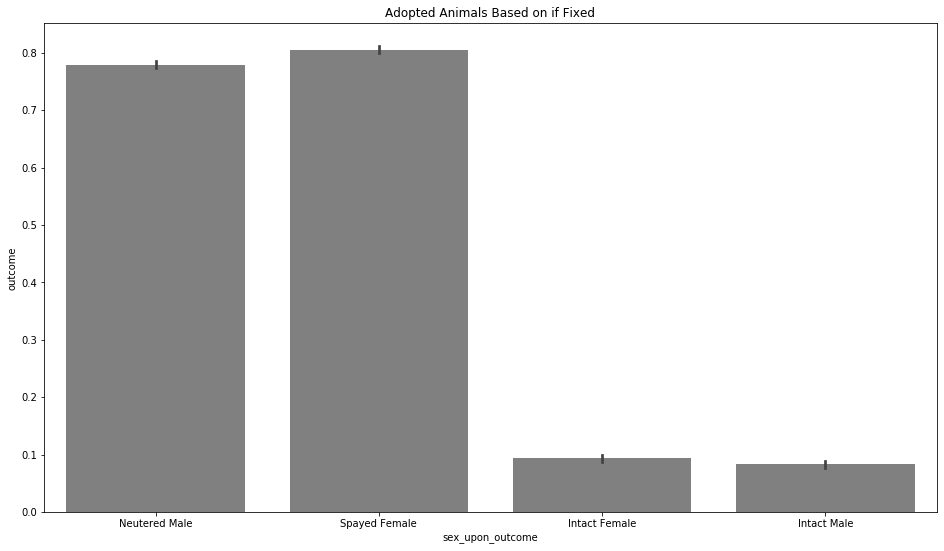

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16,9))
sns.barplot(
    x=adoption_final['sex_upon_outcome'], 
    y=adoption_final['outcome']=='Adopted', 
    color='grey'
)
plt.title('Adopted Animals Based on if Fixed');

In [118]:
#need to bin ages:
adoption_final['age_upon_outcome'].value_counts()

2 months     10544
1 year        9456
2 years       7457
3 months      3974
1 month       3689
3 years       2848
4 months      2471
5 months      1602
5 years       1558
4 years       1535
6 months      1409
3 weeks       1292
2 weeks       1008
6 years        991
8 months       961
4 weeks        949
8 years        921
10 months      838
7 years        825
7 months       785
10 years       764
9 months       614
9 years        436
12 years       378
11 months      338
1 weeks        319
11 years       234
1 week         220
13 years       209
2 days         133
14 years       131
15 years       110
3 days          99
5 weeks         85
6 days          67
1 day           63
4 days          63
5 days          36
16 years        35
0 years         25
17 years        25
18 years        14
19 years         7
20 years         6
22 years         1
-1 years         1
Name: age_upon_outcome, dtype: int64

In [119]:
# This is difficult because of the age units, there are days, weeks, months
# and years. Best way I could think of it is to bin the ages that are under 1 year
# and then do the rest of the data in years since that's the majority and it's numerical data.

def bin_ages(age):
    if age == '1 month' or age == '3 weeks' or age == '2 weeks' or age == '4 weeks' or age == '1 weeks' or age == '1 week' or age == '2 days' or age == '3 days' or age == '1 day' or age == '6 days' or age == '4 days' or age == '5 days' or age == '0 years' or age == '5 weeks' or age == '2 months' or age == '3 months' or age == '2 month' or age == '-1 years':
        return .25
    if age == '6 months' or age == '7 months' or age =='5 months' or age == '4 months':
        return .5
    if age == '8 months' or age == '9 months' or age == '10 months':
        return .75
    if age == '11 months' or age == '12 months' or age == '1 year':
        return 1
    if age == '2 years':
        return 2
    if age == '3 years':
        return 3
    if age == '4 years':
        return 4
    if age == '5 years':
        return 5
    if age == '6 years':
        return 6
    if age == '7 years':
        return 7
    if age == '8 years':
        return 8
    if age == '9 years':
        return 9
    if age == '10 years':
        return 10
    if age == '11 years' or age == '12 years' or age == '13 years' or age == '14 years' or age == '15 years' or age == '16 years' or age == '17 years' or age == '18 years' or age == '19 years' or age == '20 years' or age == '21 years' or age == '22 years':
        return 11
adoption_final['age'] = adoption_final['age_upon_outcome'].apply(bin_ages)

In [120]:
# drop age_upon_outcome column:
adoption_final = adoption_final.drop(columns='age_upon_outcome')

In [121]:
adoption_final['age'].value_counts(dropna=False)

0.25     22567
1.00      9794
2.00      7457
0.50      6267
3.00      2848
0.75      2413
5.00      1558
4.00      1535
11.00     1150
6.00       991
8.00       921
7.00       825
10.00      764
9.00       436
Name: age, dtype: int64

In [122]:
def fixed(feature):
    if 'Spayed' in feature or 'Neutered' in feature:
        return 'Fixed'
    if 'Intact' in feature:
        return 'Intact'
adoption_final['fixed'] = adoption_final['sex_upon_outcome'].apply(fixed)

In [123]:
adoption_final = pd.get_dummies(adoption_final, columns=['fixed'])
adoption_final.head()

,animal_id,animal_type,sex_upon_outcome,breed,color,outcome,month_arrived,season_arrived,year_arrived,age,fixed_Fixed,fixed_Intact
0,A644452,Dog,Neutered Male,Pit Bull Mix,Brown Brindle/White,Adopted,11,Fall,2019,8.00,1,0
11,A808933,Dog,Spayed Female,Labrador Retriever Mix,Tan,Adopted,11,Fall,2019,0.50,1,0
14,A808077,Dog,Neutered Male,American Bulldog Mix,White/Blue,Adopted,11,Fall,2019,0.25,1,0
15,A808997,Dog,Neutered Male,Labrador Retriever/German Shepherd,Brown/Tan,Adopted,11,Fall,2019,0.25,1,0
17,A804174,Dog,Spayed Female,Staffordshire Mix,Black/White,Adopted,11,Fall,2019,2.00,1,0


In [124]:
def gender(feature):
    if 'Female' in feature:
        return 'Female'
    if 'Male' in feature:
        return 'Male'
adoption_final['gender'] = adoption_final['sex_upon_outcome'].apply(gender)

In [125]:
# drop sex_upon_outcome feature:
adoption_final = adoption_final.drop(columns='sex_upon_outcome')

In [126]:
import numpy as np
# lets see if an animal being classified as pitbull or pitbull mix has any
# importance since pitbulls aren't banned in Austin but a lot of renters prohibit
# tenants from owning this breed.
breeds=['Pit Bull', 'Staffordshire']
adoption_final['pit_bull']= (np.where(adoption_final['breed'].str.contains(
    'Pit Bull|Staffordshire'), 'Y', 'N'))
adoption_final['pit_bull'].value_counts()

N    53721
Y     5805
Name: pit_bull, dtype: int64

In [127]:
adoption_final.head()

,animal_id,animal_type,breed,color,outcome,month_arrived,season_arrived,year_arrived,age,fixed_Fixed,fixed_Intact,gender,pit_bull
0,A644452,Dog,Pit Bull Mix,Brown Brindle/White,Adopted,11,Fall,2019,8.00,1,0,Male,Y
11,A808933,Dog,Labrador Retriever Mix,Tan,Adopted,11,Fall,2019,0.50,1,0,Female,N
14,A808077,Dog,American Bulldog Mix,White/Blue,Adopted,11,Fall,2019,0.25,1,0,Male,N
15,A808997,Dog,Labrador Retriever/German Shepherd,Brown/Tan,Adopted,11,Fall,2019,0.25,1,0,Male,N
17,A804174,Dog,Staffordshire Mix,Black/White,Adopted,11,Fall,2019,2.00,1,0,Female,Y


Think I'm ready to start fitting models, may need to come back to features:

In [128]:
adoption_final.to_csv('adoption_final.csv')

In [129]:
# split data into train, val, test
adoption_final['year_arrived'].value_counts()

2017    10821
2015    10529
2016    10519
2019    10471
2018     9914
2014     7272
Name: year_arrived, dtype: int64

In [130]:
test = adoption_final[(adoption_final['year_arrived'] == 2019)]  
val =  adoption_final[(adoption_final['year_arrived']== 2018)]  
train = adoption_final[(adoption_final['year_arrived'] < 2018)]

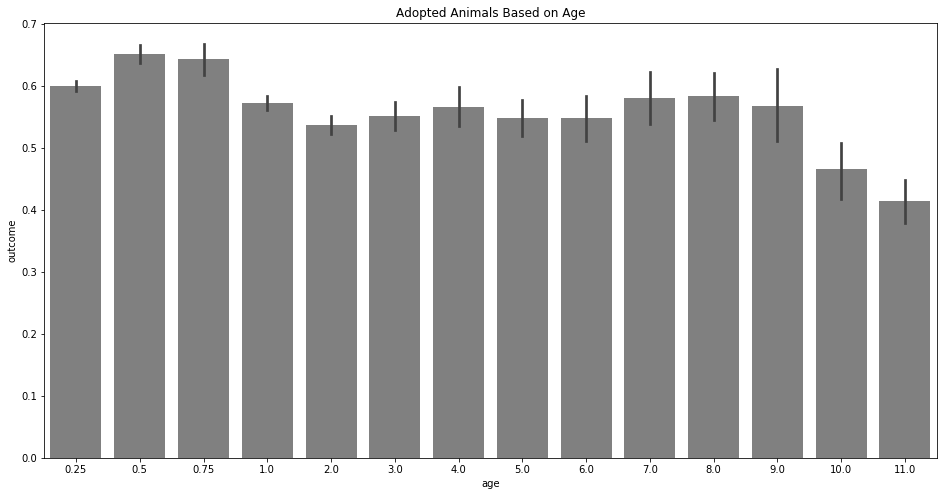

In [131]:
import seaborn as sns
plt.figure(figsize=(16,8))
sns.barplot(
    x=train['age'], 
    y=train['outcome']=='Adopted', 
    color='grey'
)
plt.title('Adopted Animals Based on Age');

In [132]:
# X features matrices and y target vectors:
target = 'outcome'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [133]:
X_train = X_train.drop(columns=['fixed_Intact'])
X_val = X_val.drop(columns=['fixed_Intact'])
X_test = X_test.drop(columns=['fixed_Intact'])

In [134]:
X_train.shape, X_val.shape, X_test.shape

((39141, 11), (9914, 11), (10471, 11))

In [135]:
y_train.shape, y_val.shape, y_test.shape

((39141,), (9914,), (10471,))

In [136]:
# separating out transformers to get permutation importances.
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
encoder = make_pipeline(
    ce.OrdinalEncoder()
)

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = RandomForestClassifier(n_estimators=242, max_depth=5, 
                               max_features=0.3153875509595685, random_state=42, 
                               n_jobs=-1)
model.fit(X_train_encoded, y_train)


print('Validation Accuracy', model.score(X_val_encoded, y_val))

Validation Accuracy 0.8634254589469437


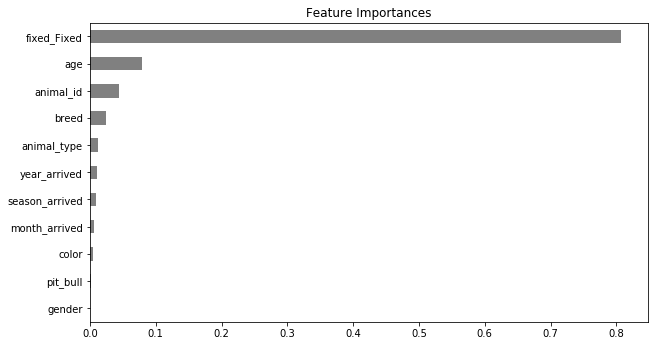

In [137]:
# Get feature importances
importances = pd.Series(model.feature_importances_, X_val.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 11
plt.figure(figsize=(10,n/2))
plt.title(f'Feature Importances')
importances.sort_values()[-n:].plot.barh(color='grey');

In [138]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_encoded, y_val)
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.2956 ± 0.0122,fixed_Fixed
0.0001 ± 0.0000,animal_id
0.0001 ± 0.0001,gender
0.0001 ± 0.0001,season_arrived
0.0001 ± 0.0001,month_arrived
0.0001 ± 0.0001,breed
0.0001 ± 0.0001,animal_type
0.0000 ± 0.0001,age
0.0000 ± 0.0001,pit_bull
0 ± 0.0000,year_arrived


In [139]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_perm = X_train[features]

In [140]:
# accuracy went down when we removed the features that had less than 0 
# importance. Validation accuracy went down so will keep all of the features.
X_val_perm = X_val[features]

perm_pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=242, max_depth=5, 
                               max_features=0.3153875509595685, random_state=42, 
                               n_jobs=-1)
)
# Fit on train, score on val
perm_pipeline.fit(X_train_perm, y_train)
print('Validation Accuracy', perm_pipeline.score(X_val_perm, y_val))

Validation Accuracy 0.8633245914867863


In [141]:
# # going to do RandomizedSearchCV for optimized hyperparameters:
# from scipy.stats import randint, uniform
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# transformers = make_pipeline(
#     ce.OrdinalEncoder()
# )

# X_train_transformed = transformers.fit_transform(X_train)
# X_val_transformed = transformers.transform(X_val)

# model = make_pipeline(
#     RandomForestClassifier(random_state=42)
# )
# # model.fit(X_train_transformed, y_train)
# # pipeline = make_pipeline(
# #     ce.OrdinalEncoder(), 
# #     RandomForestClassifier(random_state=42)
# # )

# param_distributions = {
#     'randomforestclassifier__n_estimators': randint(50, 500, 10), 
#     'randomforestclassifier__max_depth': [5, 10, 15, None], 
#     'randomforestclassifier__max_features': uniform(0, 1), 
# }

# search = RandomizedSearchCV(
#     model, 
#     param_distributions=param_distributions, 
#     n_iter=100, 
#     cv=5, 
#     scoring='accuracy', 
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-1
# )

# search.fit(X_train_transformed, y_train);

In [142]:
# print('Best hyperparameters', search.best_params_)
# print('Cross-validation Accuracy', search.best_score_)

In [143]:
# with hyper-parameters:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

final_model = RandomForestClassifier(n_estimators=479, max_depth=5, 
                               max_features=0.12718863383484313, random_state=42, 
                               n_jobs=-1)
final_model.fit(X_train_encoded, y_train)


print('Validation Accuracy', final_model.score(X_val_encoded, y_val))

Validation Accuracy 0.8634254589469437


In [144]:
# all together in 1 pipeline:
thepipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=479, max_depth=5, 
                               max_features=0.12718863383484313, random_state=42, 
                               n_jobs=-1)
)
# Fit on train, score on val
thepipeline.fit(X_train, y_train)
print('Validation Accuracy', thepipeline.score(X_val, y_val))

Validation Accuracy 0.8634254589469437


In [145]:
# test score
y_pred =final_model.predict(X_test_encoded)
class_index=1
y_pred_proba = final_model.predict_proba(X_test_encoded)[:, class_index]
score = final_model.score(X_test_encoded, y_test)
print(f'Test Score: {score}')

Test Score: 0.8772801069620858


In [146]:
encoder.mapping

[{'col': 'animal_id', 'mapping': A764288        1
  A764061        2
  A764032        3
  A764304        4
  A764301        5
  A764290        6
  A764302        7
  A764251        8
  A764523        9
  A764522       10
  A764524       11
  A764287       12
  A763835       13
  A763180       14
  A764081       15
  A764083       16
  A761345       17
  A762304       18
  A757894       19
  A680174       20
  A764003       21
  A764408       22
  A757274       23
  A764035       24
  A763536       25
  A728770       26
  A758870       27
  A759966       28
  A762687       29
  A721103       30
             ...  
  A680619    36533
  A680622    36534
  A680621    36535
  A680620    36536
  A679095    36537
  A679323    36538
  A678090    36539
  A675849    36540
  A680542    36541
  A680529    36542
  A680423    36543
  A680229    36544
  A680430    36545
  A680245    36546
  A680122    36547
  A680226    36548
  A678459    36549
  A680123    36550
  A679680    36551
  A675848    36552


# Visualizations

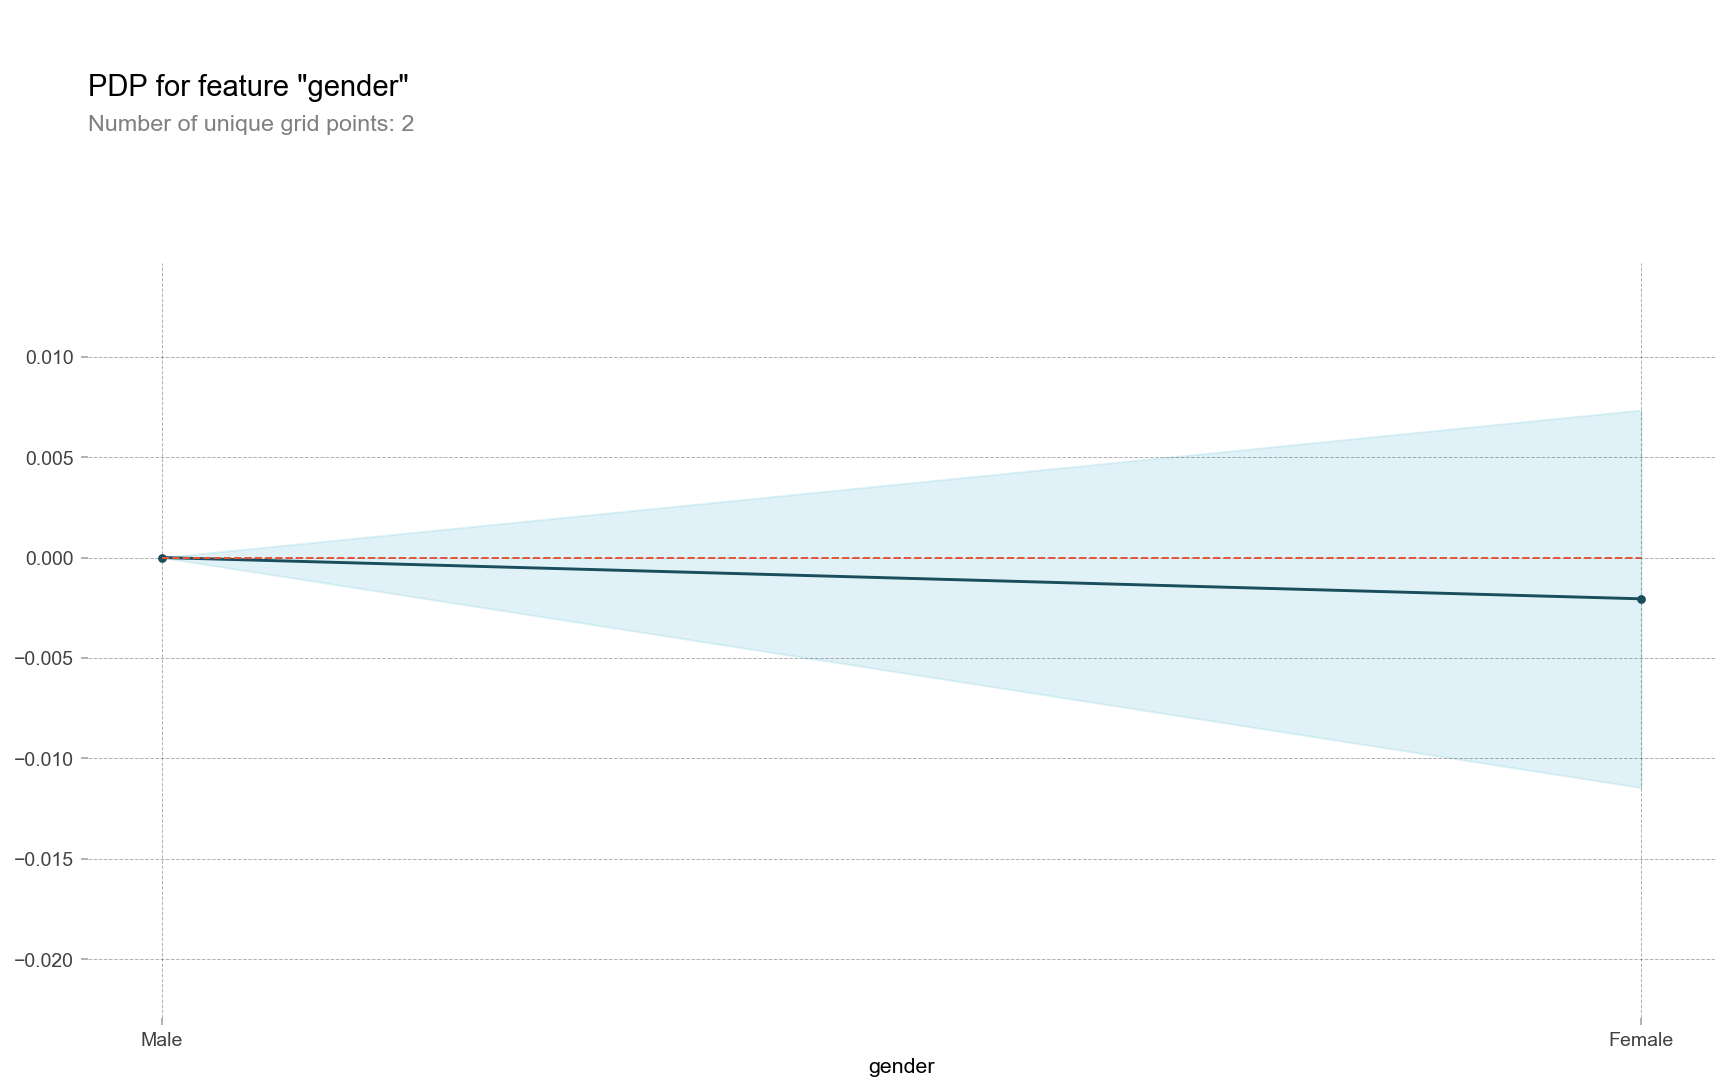

In [147]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt
from pdpbox import pdp
%matplotlib inline
#encoded data:
encoded = X_val_encoded
model = final_model
model.fit(X_val_encoded, y_val)

plt.rcParams['figure.dpi'] = 140
# gender feature
feature2='gender'
for item in encoder.mapping:
    if item['col'] == feature2:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()
pdp_dist = pdp.pdp_isolate(model=final_model, dataset=encoded, model_features=encoded.columns, feature=feature2)
pdp.pdp_plot(pdp_dist, feature2)
plt.xticks(category_codes, category_names);

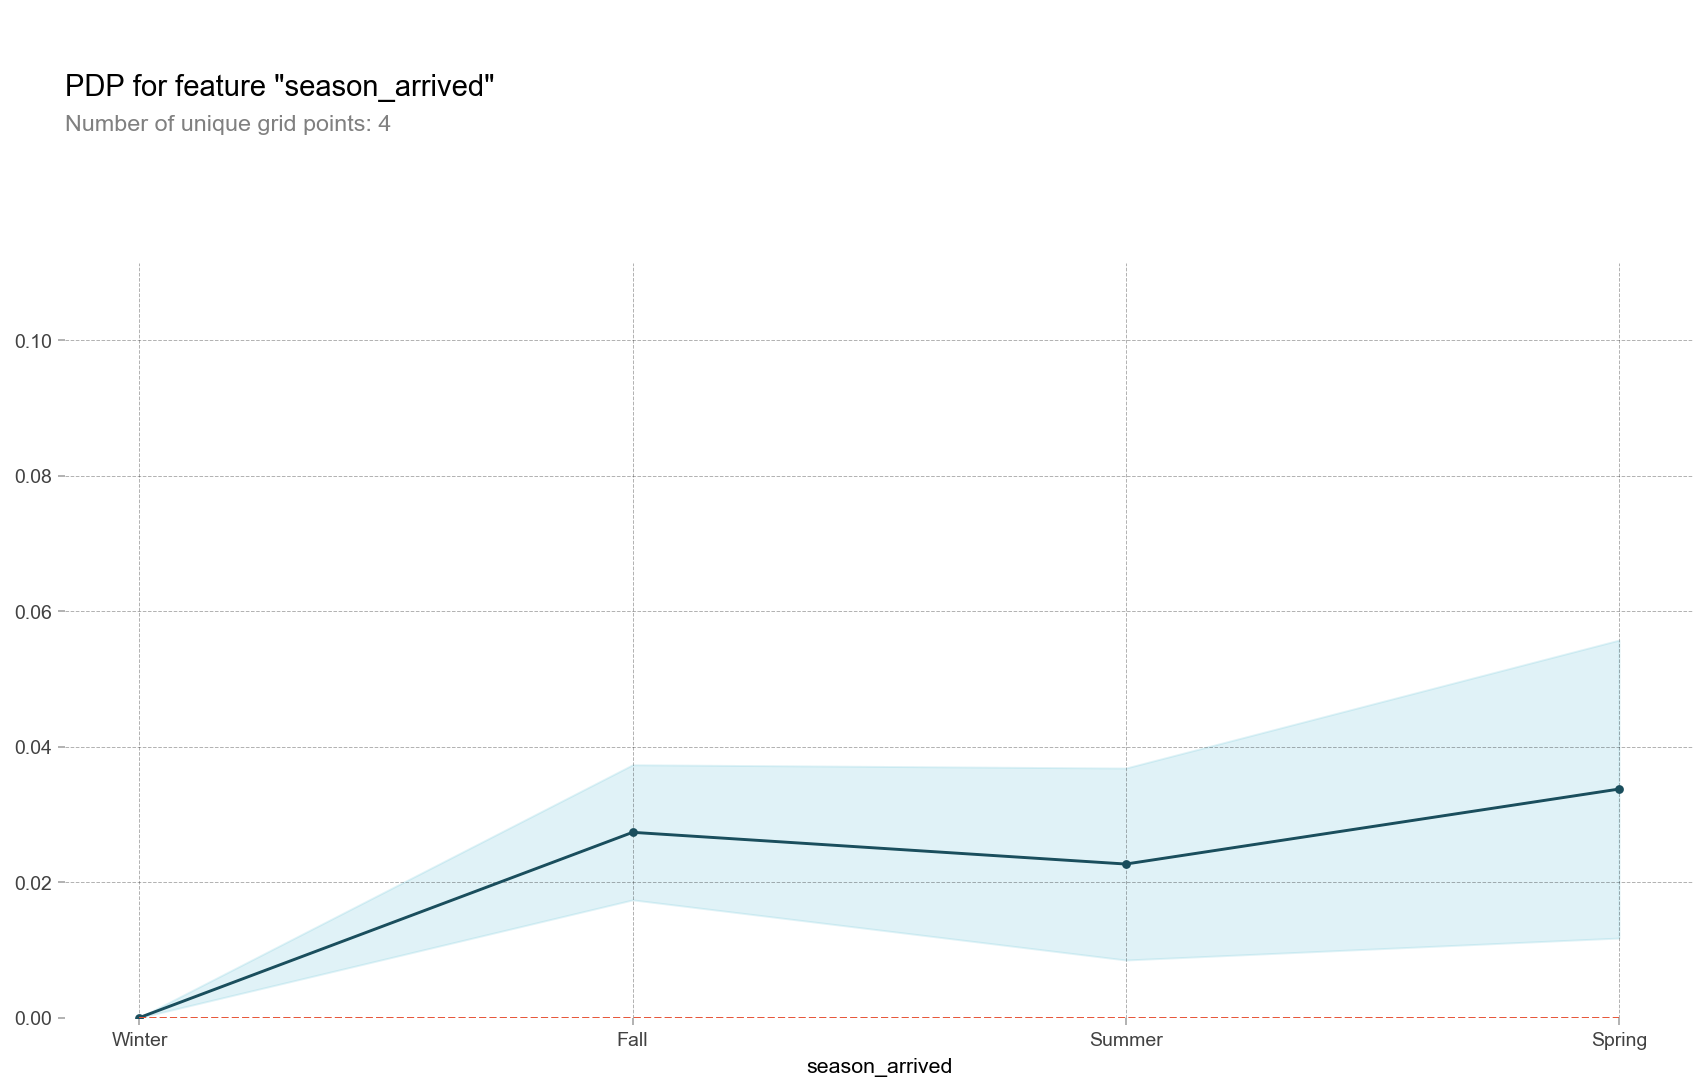

In [148]:
# season_arrived
feature3='season_arrived'
for item in encoder.mapping:
    if item['col'] == feature3:
        feature_mapping = item['mapping']
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()
pdp_dist = pdp.pdp_isolate(model=model, dataset=encoded, model_features=encoded.columns, feature=feature3)
pdp.pdp_plot(pdp_dist, feature3)
plt.xticks(category_codes, category_names);

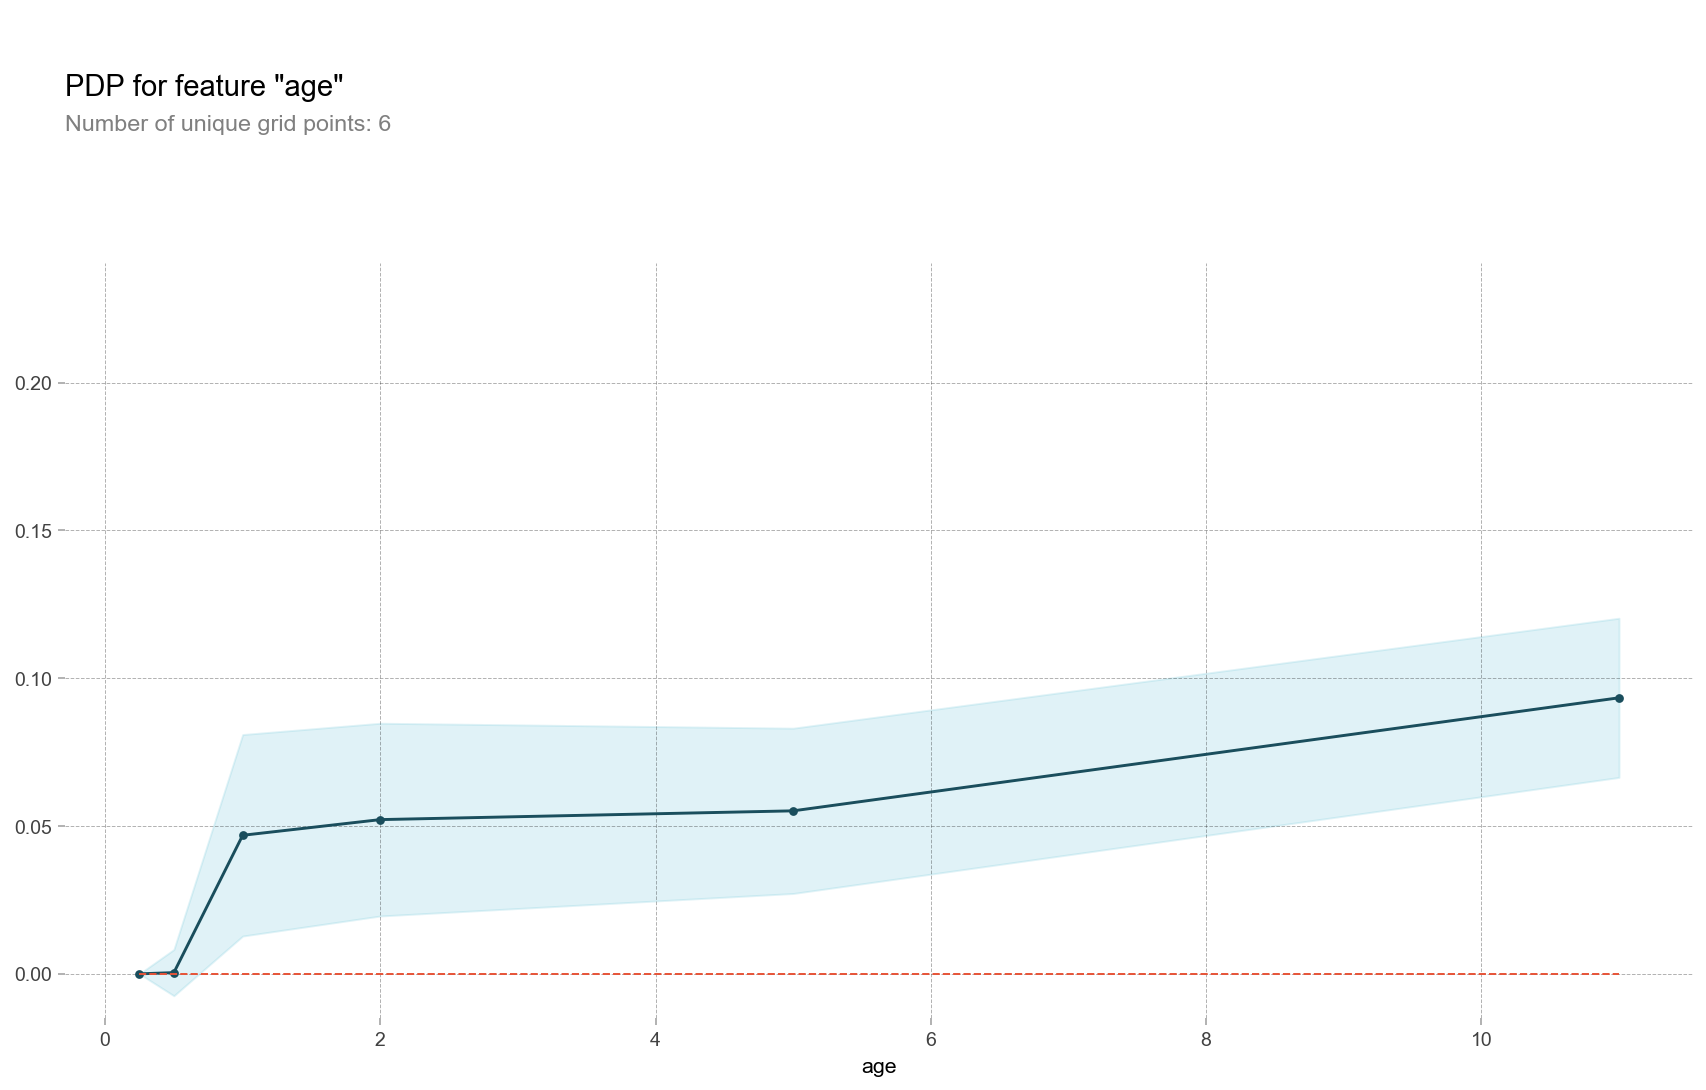

In [149]:
# 1 feature numerical PDP
plt.rcParams['figure.dpi'] = 140
from pdpbox.pdp import pdp_isolate, pdp_plot
feature4 = 'age'
isolated = pdp_isolate(
    model=model, 
    dataset=encoded, 
    model_features=encoded.columns, 
    feature=feature4
)
pdp_plot(isolated, feature_name=feature4);

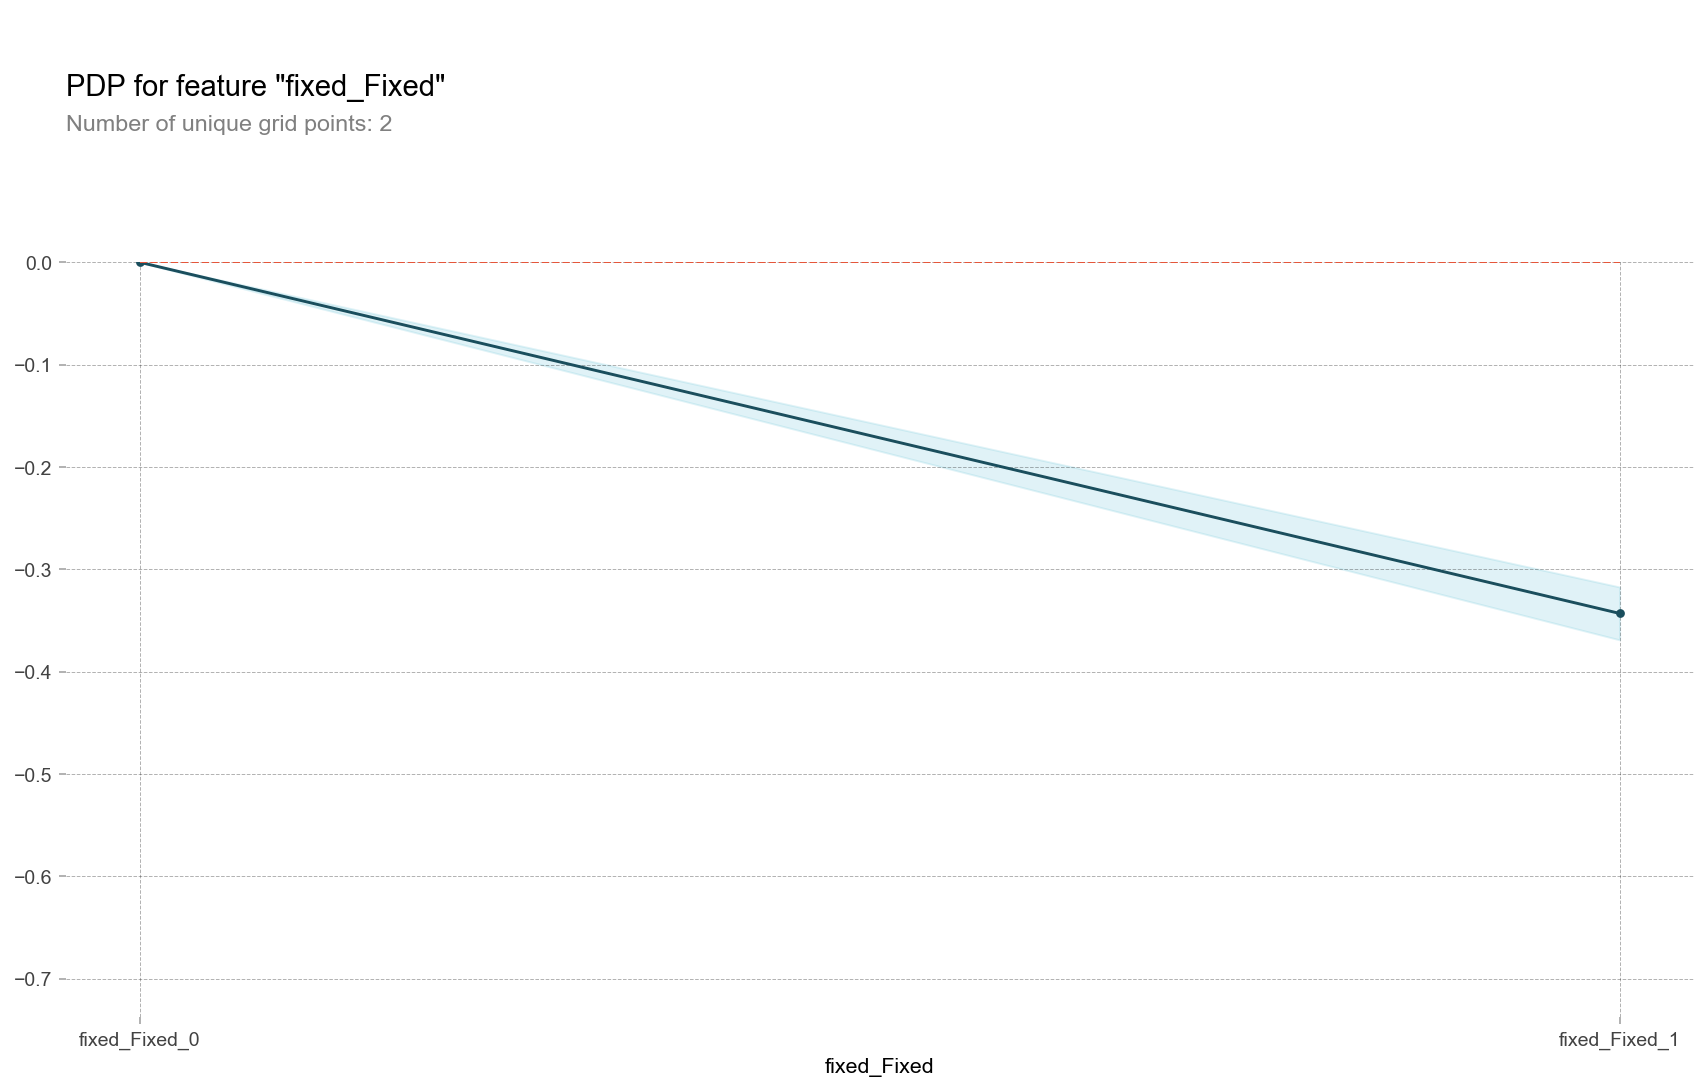

In [150]:
plt.rcParams['figure.dpi'] = 140
from pdpbox.pdp import pdp_isolate, pdp_plot
feature5 = 'fixed_Fixed'
isolated = pdp_isolate(
    model=model, 
    dataset=encoded, 
    model_features=encoded.columns, 
    feature=feature5
)
pdp_plot(isolated, feature_name=feature5);

In [151]:
encoder.mapping

[{'col': 'animal_id', 'mapping': A764288        1
  A764061        2
  A764032        3
  A764304        4
  A764301        5
  A764290        6
  A764302        7
  A764251        8
  A764523        9
  A764522       10
  A764524       11
  A764287       12
  A763835       13
  A763180       14
  A764081       15
  A764083       16
  A761345       17
  A762304       18
  A757894       19
  A680174       20
  A764003       21
  A764408       22
  A757274       23
  A764035       24
  A763536       25
  A728770       26
  A758870       27
  A759966       28
  A762687       29
  A721103       30
             ...  
  A680619    36533
  A680622    36534
  A680621    36535
  A680620    36536
  A679095    36537
  A679323    36538
  A678090    36539
  A675849    36540
  A680542    36541
  A680529    36542
  A680423    36543
  A680229    36544
  A680430    36545
  A680245    36546
  A680122    36547
  A680226    36548
  A678459    36549
  A680123    36550
  A679680    36551
  A675848    36552


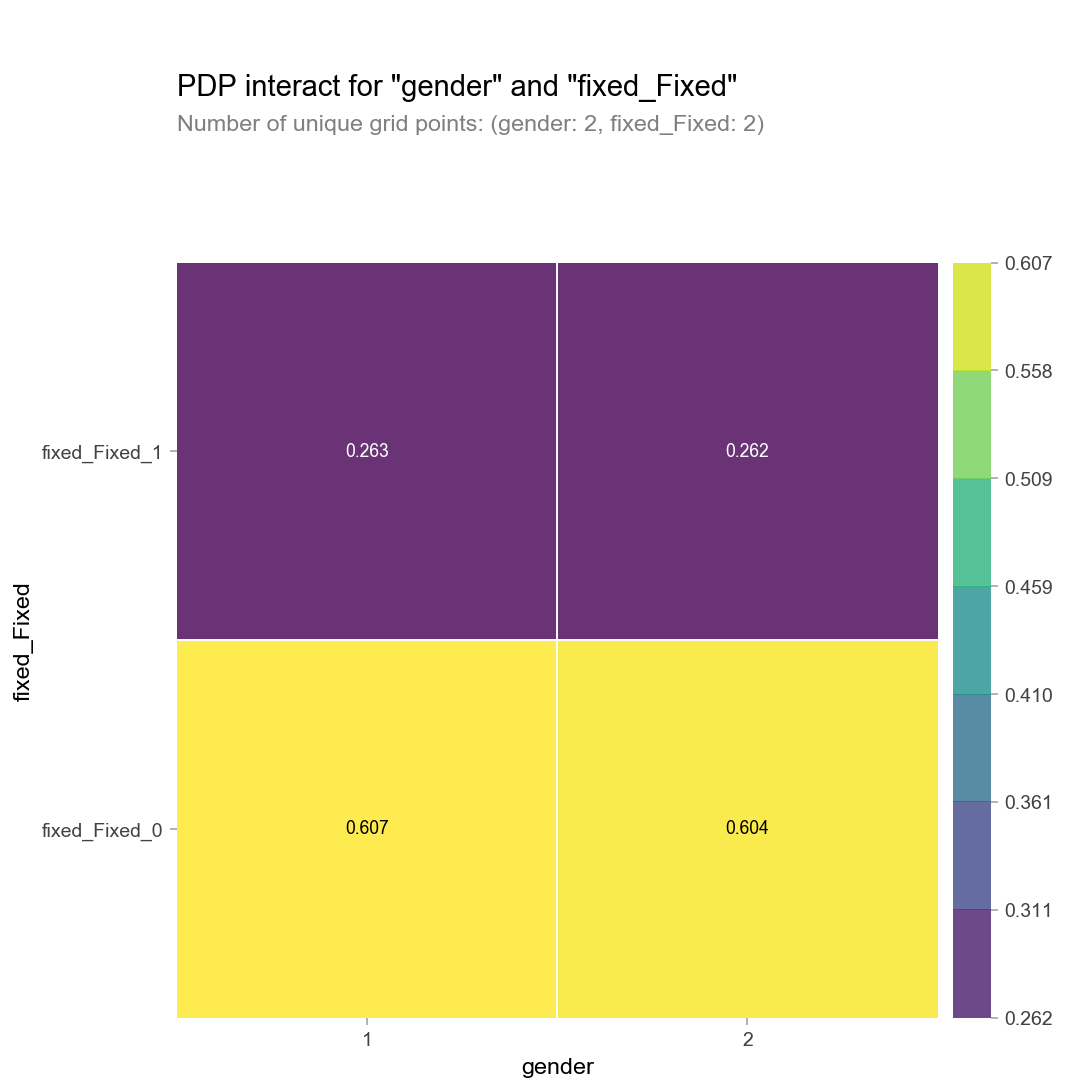

In [152]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['gender', 'fixed_Fixed']

interaction = pdp_interact(
    model=model, 
    dataset=encoded, 
    model_features=encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);
# not really interesting

# Logistic Regression

In [153]:
from sklearn.linear_model import LogisticRegression
lr = make_pipeline(
    ce.OrdinalEncoder(),
    LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
)

lr.fit(X_train, y_train)
print('Logistic Regression:')
print('Train Accuracy', lr.score(X_train, y_train))
print('Validation Accuracy', lr.score(X_val, y_val))

Logistic Regression:
Train Accuracy 0.774967425461792
Validation Accuracy 0.7384506758119831


## Shapley Values

In [154]:
train_id = X_train['animal_id']
val_id = X_val['animal_id']
test_id = X_test['animal_id']
y_pred_proba

array([0.31832156, 0.25802724, 0.27400254, ..., 0.5890112 , 0.60664858,
       0.62193317])

In [155]:
df = pd.DataFrame({
    'animal_id': test_id, 
    'pred_proba': y_pred_proba, 
    'outcome': y_test
})
df = df.merge(X_test[['animal_id','breed', 'gender', 'fixed_Fixed', 'age', 'color', 'season_arrived',
                    'month_arrived', 'year_arrived', 'animal_type','pit_bull']],
    how='left')

In [156]:
df.shape, X_test.shape


((11645, 13), (10471, 11))

In [157]:
Adopted = df['outcome'] == 'Adopted'
Not_Adopted = ~Adopted
right = (Adopted) == (df['pred_proba'] > 0.50)
wrong = ~right

In [158]:
df[Adopted & right].sample(n=15, random_state=1).sort_values(by='pred_proba', ascending=False)

,animal_id,pred_proba,outcome,breed,gender,fixed_Fixed,age,color,season_arrived,month_arrived,year_arrived,animal_type,pit_bull
10372,A792980,0.614699,Adopted,Domestic Shorthair Mix,Male,0,0.25,Brown Tabby,Spring,5,2019,Cat,N
10849,A791254,0.610726,Adopted,Domestic Shorthair Mix,Male,0,0.25,Blue Tabby/White,Spring,3,2019,Cat,N
3627,A792948,0.586748,Adopted,Miniature Poodle Mix,Male,0,11.00,Blue,Fall,10,2019,Dog,N
9144,A797790,0.576723,Adopted,Domestic Shorthair,Female,0,0.25,Brown Tabby,Summer,6,2019,Cat,N
2267,A776022,0.575624,Adopted,Dachshund Mix,Male,0,11.00,Black,Summer,7,2019,Dog,N
9156,A797878,0.574162,Adopted,Domestic Shorthair,Female,0,0.25,Tortie,Summer,6,2019,Cat,N
9219,A797347,0.574162,Adopted,Domestic Shorthair,Female,1,0.50,Tortie,Fall,10,2019,Cat,N
9221,A797348,0.574162,Adopted,Domestic Shorthair,Female,1,0.50,Tortie,Fall,9,2019,Cat,N
1235,A802737,0.573190,Adopted,Boxer,Female,0,5.00,Brown/White,Fall,9,2019,Dog,N
343,A806841,0.573099,Adopted,Beagle Mix,Female,0,2.00,White/Brown,Fall,10,2019,Dog,N


In [159]:
row = X_test.loc[X_test['animal_id']=='A792980']

row

,animal_id,animal_type,breed,color,month_arrived,season_arrived,year_arrived,age,fixed_Fixed,gender,pit_bull
11920,A792980,Cat,Domestic Shorthair Mix,Brown Tabby,5,Spring,2019,0.25,0,Male,N


In [160]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = encoder.transform(row)
shap_value = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_value[0],
    features=row,  
    link='logit' # For classification, this shows predicted probabilities
)

In [161]:
df[Adopted & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba', ascending=False)[:25]

,animal_id,pred_proba,outcome,breed,gender,fixed_Fixed,age,color,season_arrived,month_arrived,year_arrived,animal_type,pit_bull
11382,A787891,0.367989,Adopted,Domestic Shorthair Mix,Male,1,6.00,Black/White,Winter,1,2019,Cat,N
7383,A803143,0.298346,Adopted,Domestic Shorthair,Female,1,0.25,Black,Fall,9,2019,Cat,N
9257,A794797,0.297374,Adopted,Domestic Medium Hair,Female,1,0.25,White/Gray,Summer,6,2019,Cat,N
3398,A793374,0.295308,Adopted,Chihuahua Shorthair Mix,Female,1,2.00,White,Spring,4,2019,Dog,N
7660,A799630,0.288641,Adopted,Domestic Shorthair,Female,1,0.25,Blue Tabby,Summer,8,2019,Cat,N
7704,A802353,0.285910,Adopted,Domestic Shorthair,Male,1,0.25,Brown Tabby/White,Summer,8,2019,Cat,N
4253,A790319,0.283244,Adopted,Chihuahua Shorthair Mix,Female,1,1.00,Red,Spring,3,2019,Dog,N
2198,A796391,0.276603,Adopted,Catahoula Mix,Female,1,1.00,Brown,Summer,6,2019,Dog,N
3095,A792947,0.268337,Adopted,Yorkshire Terrier Mix,Male,1,0.25,Tricolor,Spring,5,2019,Dog,N
5357,A776864,0.257855,Adopted,Labrador Retriever Mix,Female,1,1.00,Tan,Winter,1,2019,Dog,N


In [162]:
row1 = X_test.loc[X_test['animal_id']=='A793217']

row1

,animal_id,animal_type,breed,color,month_arrived,season_arrived,year_arrived,age,fixed_Fixed,gender,pit_bull
12217,A793217,Dog,Pit Bull Mix,Blue/White,5,Spring,2019,1.0,1,Male,Y


In [163]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = encoder.transform(row1)
shap_value = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_value[0],
    features=row,  
    link='logit' # For classification, this shows predicted probabilities
)

In [164]:
df[Not_Adopted & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,animal_id,pred_proba,outcome,breed,gender,fixed_Fixed,age,color,season_arrived,month_arrived,year_arrived,animal_type,pit_bull
4561,A789595,0.285318,Not adopted,Rat Terrier Mix,Male,1,4.00,White/Brown,Winter,2,2019,Dog,N
3881,A789967,0.301481,Not adopted,American Bulldog Mix,Male,1,2.00,White/Tan,Spring,4,2019,Dog,N
4306,A790200,0.304950,Not adopted,Chihuahua Shorthair/Dachshund,Male,1,4.00,Red,Spring,3,2019,Dog,N
661,A803935,0.308018,Not adopted,Boxer,Female,1,5.00,Tan/White,Fall,9,2019,Dog,N
2326,A798838,0.310401,Not adopted,Great Pyrenees,Male,1,7.00,White,Summer,7,2019,Dog,N
4669,A697222,0.325733,Not adopted,Queensland Heeler Mix,Male,1,6.00,Black/Tan,Winter,2,2019,Dog,N
5677,A804055,0.338415,Not adopted,Domestic Shorthair,Female,1,0.75,Calico,Fall,11,2019,Cat,N
6488,A804627,0.389796,Not adopted,Domestic Shorthair,Male,1,10.00,Orange Tabby,Fall,10,2019,Cat,N
7467,A802964,0.389884,Not adopted,Domestic Shorthair Mix,Male,1,2.00,Brown Tabby,Summer,8,2019,Cat,N
11137,A789726,0.394236,Not adopted,Domestic Shorthair Mix,Male,1,10.00,Brown Tabby/White,Winter,2,2019,Cat,N


In [165]:
df[Not_Adopted & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,animal_id,pred_proba,outcome,breed,gender,fixed_Fixed,age,color,season_arrived,month_arrived,year_arrived,animal_type,pit_bull
284,A807590,0.551190,Not adopted,German Shepherd,Female,0,0.75,Tan/Black,Fall,11,2019,Dog,N
1176,A803875,0.566095,Not adopted,Pit Bull,Female,0,0.25,Fawn/White,Fall,9,2019,Dog,Y
7421,A803096,0.573908,Not adopted,Domestic Medium Hair,Male,0,0.25,Brown Tabby,Summer,8,2019,Cat,N
7748,A802475,0.576138,Not adopted,Domestic Shorthair Mix,Female,0,0.25,Tortie/White,Summer,8,2019,Cat,N
8269,A800523,0.577125,Not adopted,Domestic Shorthair,Female,0,0.25,Torbie/White,Summer,7,2019,Cat,N
7897,A802058,0.579354,Not adopted,Domestic Shorthair Mix,Male,0,0.25,Brown Tabby/White,Summer,8,2019,Cat,N
18,A803464,0.579849,Not adopted,Pit Bull,Female,0,2.00,Black/White,Fall,11,2019,Dog,Y
8133,A800877,0.589009,Not adopted,Domestic Shorthair Mix,Male,0,0.25,Cream Tabby,Summer,8,2019,Cat,N
10507,A793617,0.604365,Not adopted,Domestic Medium Hair Mix,Male,0,0.25,Orange Tabby,Spring,4,2019,Cat,N
7454,A803058,0.609779,Not adopted,Domestic Shorthair,Male,0,2.00,Cream Tabby/White,Summer,8,2019,Cat,N


In [166]:
# top_dogs = dogs.groupby(['breed', 'outcome'])
dogs.outcome[dogs.outcome == 'Adopted'] = 1
dogs.outcome[dogs.outcome == 'Not adopted'] = 0
top = dogs['breed'].value_counts()[:10].index
top_dogs = dogs.loc[dogs['breed'].isin(top)]
top_dogs = top_dogs[['breed', 'outcome']]

In [167]:
topc = cats['breed'].value_counts()[:10].index
top_cats = cats.loc[cats['breed'].isin(topc)]

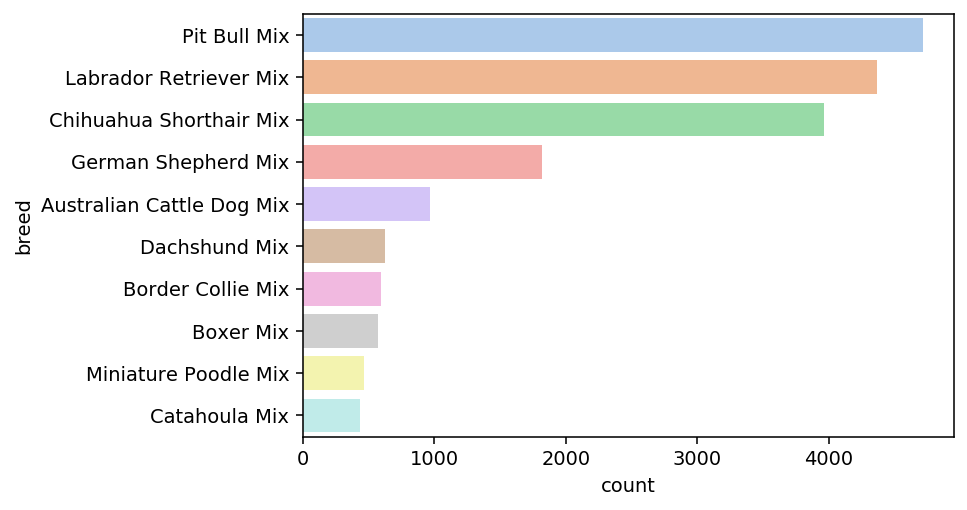

In [168]:
ax = sns.countplot(y="breed", data=top_dogs, palette='pastel', order = top_dogs['breed'].value_counts().index)

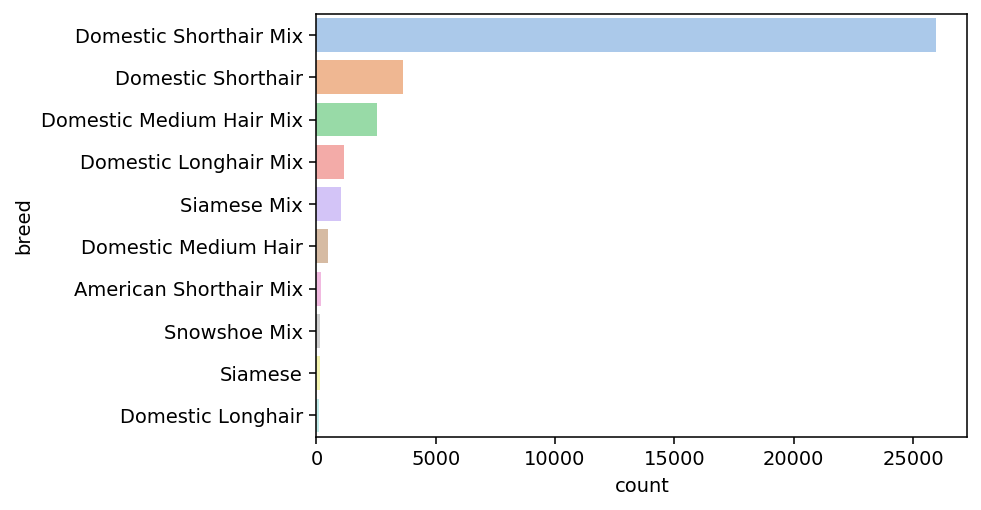

In [169]:
ax = sns.countplot(y="breed", data=top_cats, palette='pastel', order = top_cats['breed'].value_counts().index)